In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# this is needed when importing from the notebooks folder
sys.path.append("../")
from lobster import Lightcurve
from lobster.filtering import sin4_filter

Importing data from a folder containing TESS FITS files.

In [ ]:
# creating a blank lightcurve (no data inside it)
original_lc = Lightcurve()
# initializing it from a folder containing multiple FITS files
original_lc.load_qlp("data/4MOST/0000000260501932/qlp/")
# activating debug mode to track operations
original_lc.debug = True

First, we will clean the data thanks to quality bits and plot the original and cleaned data to compare them.

<Axes: title={'center': 'Flux'}, xlabel='Time (d)', ylabel='Flux (unit)'>

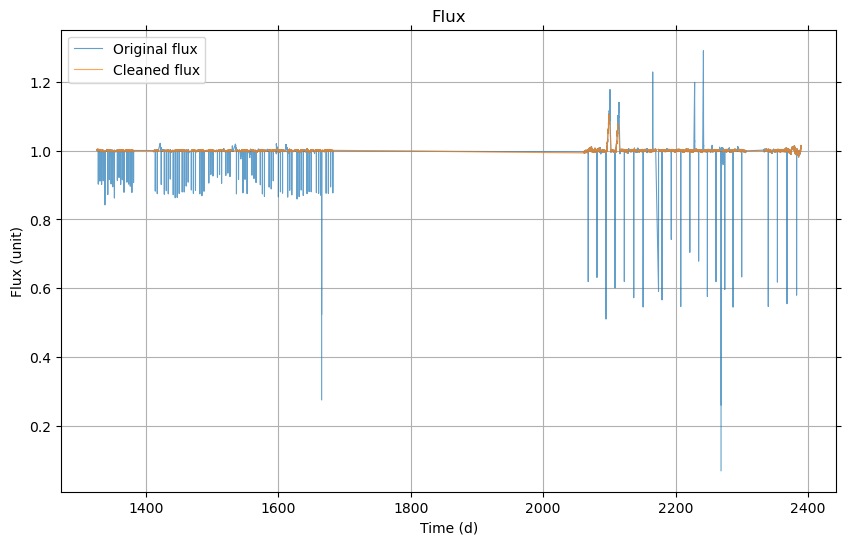

In [ ]:
# the matplotlib axis will be returned by every `lc.plot_...` function
ax = original_lc.plot_flux(label="Original flux")

# clean the data by removing non-null quality flags
lc_1 = original_lc.copy().remove_quality(quality_to_keep=[0])

# plot the result in the same matplotlib subplot to compare
lc_1.plot_flux(ax=ax, label="Cleaned flux")

We can then remove the very large gap in the center.

Here, we copy the lightcurve at every change in order to be able to re-run the notebook cells afterwards.\
It is however very unefficient memory-wise, and not needed when doing a real analysis as shown later.

<Axes: title={'center': 'Gapless flux'}, xlabel='Time (d)', ylabel='Flux (unit)'>

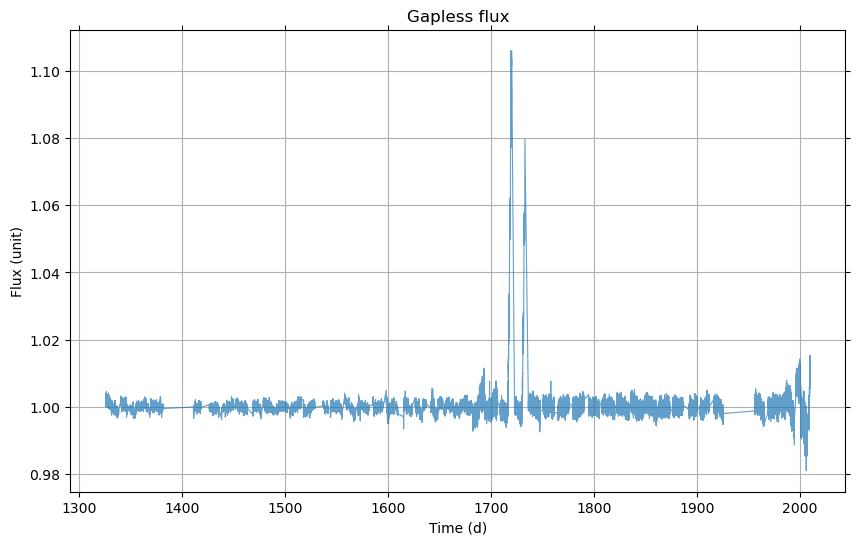

In [ ]:
lc_2 = lc_1.copy().remove_large_jumps(90)
lc_2.plot_flux(title="Gapless flux")

The next step is to filter the lightcurve in order to remove the variations we are not interested in: if we want to look at high-frequency data (to study vibration modes), we can filter with a 3 days adaptative filter, which becomes a 12h filter when the data is diverging from its long-time trend.

Because we set `lc_original.debug = True`, the debug plot for the adaptative filter will be shown.

<Axes: title={'center': 'Flux'}, xlabel='Time (d)', ylabel='Flux (unit)'>

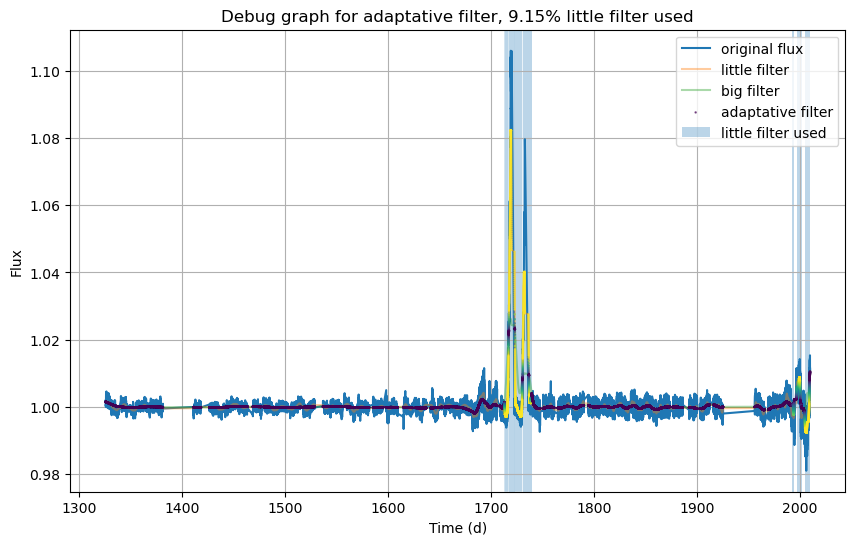

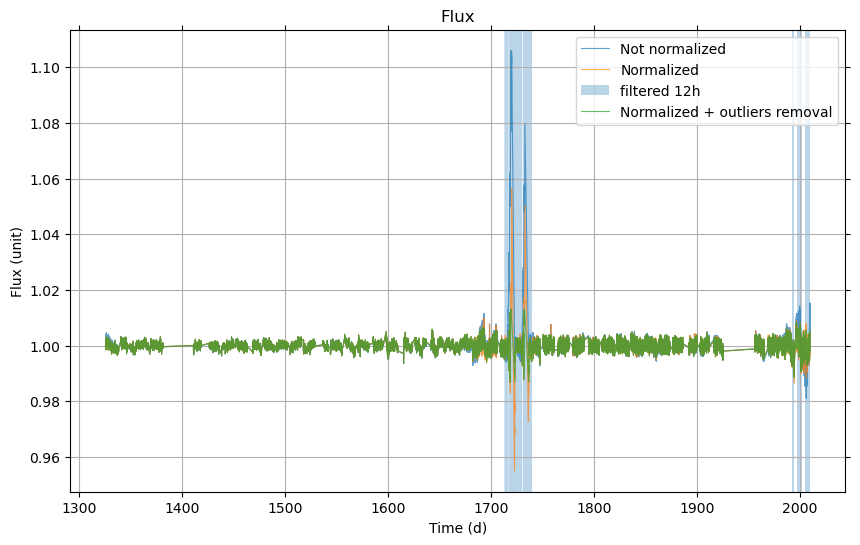

In [ ]:
# we use either a 12h or a 3d cut period, based on an indicator (that we return) which
# shows how much the flux is diverging from its long-term behaviour. The thresholds indicates
# the transition gap between the small and big window being used, increasing thresholds
# will lead to a flux being more and more normalized according to the bigger filter.
lc_3 = lc_2.copy()
indicator = lc_3.normalize_adaptative_sin4_filter(
    cut_above_periods=(1, 6), thresholds=(0.7, 1.2), return_indicators=True
)
# show the last flux
ax = lc_2.plot_flux(label="Not normalized")
# show the normalized flux
lc_3.plot_flux(ax=ax, label="Normalized")
# show the parts of the flux that was normalized with the little filter of 12h
lc_3.plot_correction_zones(ax, correction=indicator, label="filtered 12h")

# remove outliers that are left after the adaptative filter
lc_3.remove_outliers(identification_mode="sigma_clipping", threshold=5)
lc_3.remove_outliers(identification_mode="deriv_sigma_clipping", threshold=2.5)
# show the new flux
lc_3.plot_flux(ax=ax, label="Normalized + outliers removal")

With this clean version of the flux, we can now prepare it for the PSD:
- resample it with a 30' time step, because the PSD **needs** to have equally-spaced time samples
- center it around $0$ and multiply it by $10^6$ in order to use *ppm* units: this is done automatically by `flux_to_ppm`

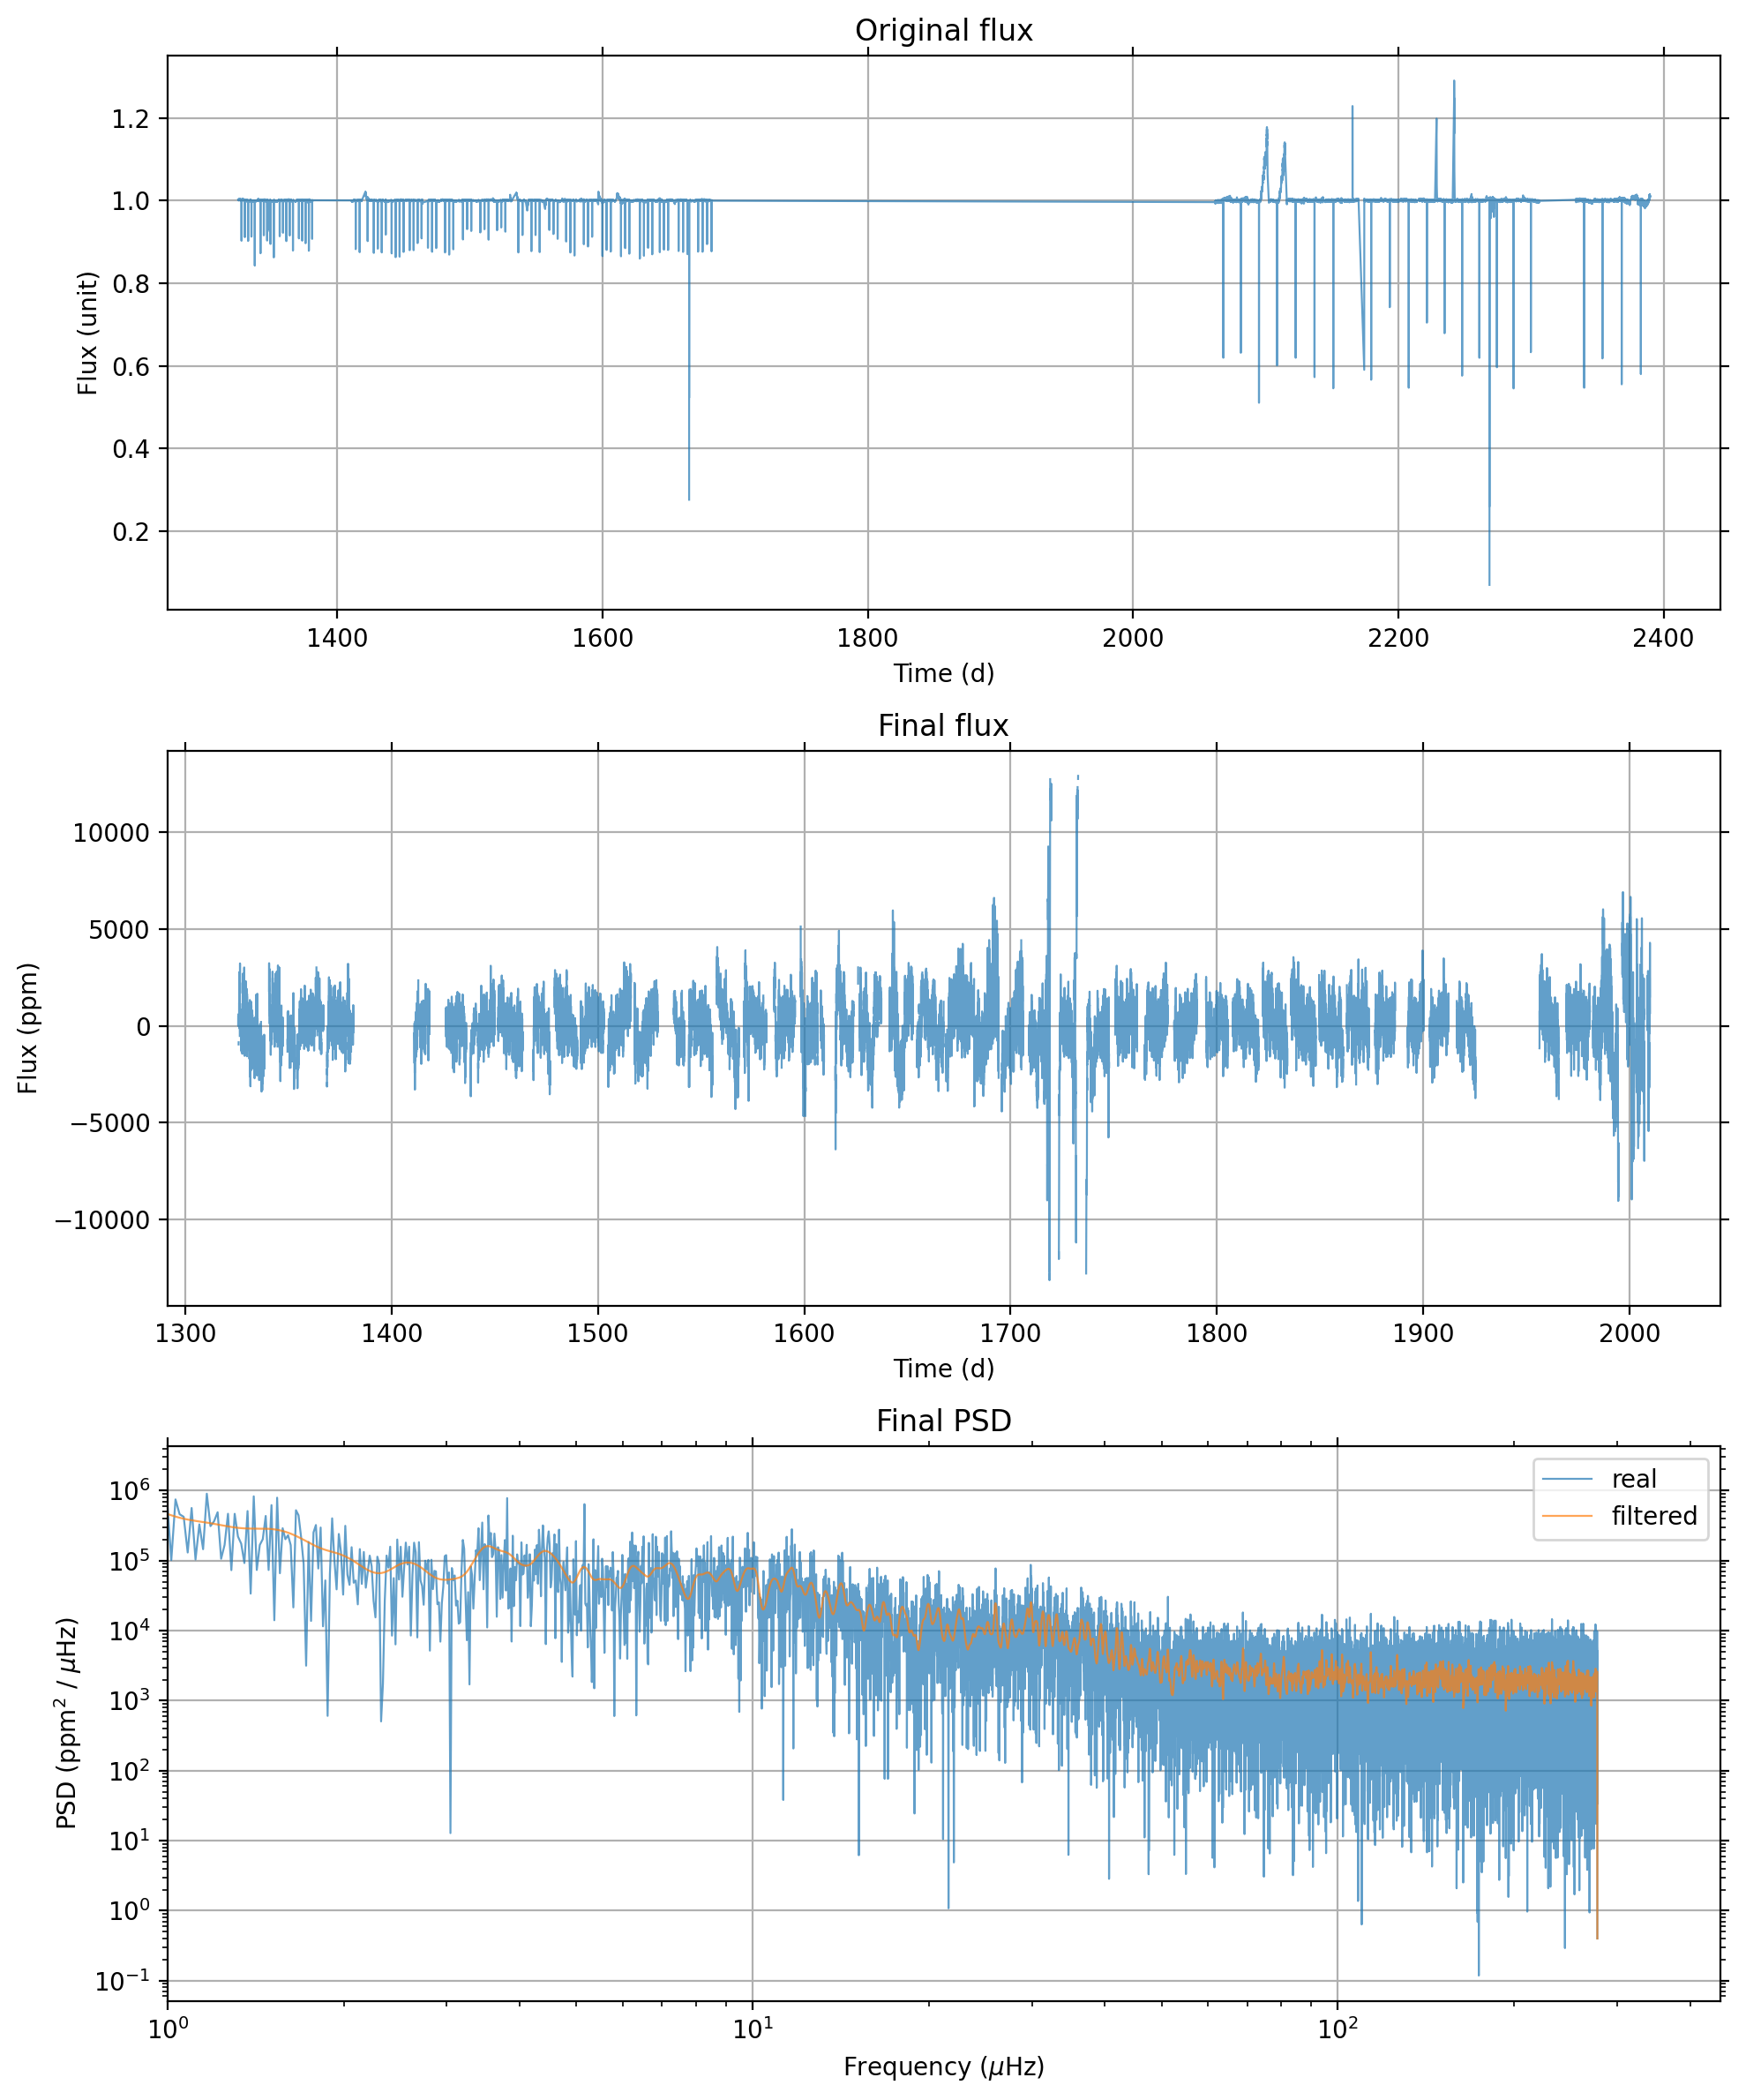

In [ ]:
# resample with a time step of 30 min = 0.5/24 d
lc_4 = lc_3.copy().resample(0.5 / 24)
# convert to ppm
lc_4.flux_to_ppm()

# create custom subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12), dpi=200)

# plot the original flux in the first subplot
original_lc.plot_flux(ax=ax1, title="Original flux")

# plot the final flux in the second subplot
lc_4.plot_flux(ax=ax2, title="Final flux")

# plot the resulting PSD in the third subplot, along with a filtered version of it
lc_4.plot_psd(ax=ax3, xlim=(1, None), label="real")
lc_4.plot_psd(
    ax=ax3,
    xlim=(1, None),
    psd_filter=lambda x: sin4_filter(x, 41),
    title="Final PSD",
    label="filtered",
)

# adapt the subplots to their content
fig.tight_layout()

Now, if we want to verify which operations have been done one the final lightcurve `lc_4`, we can use the functionnality that `original_lc.debug = True` enabled: after each operation, the time and flux arrays are saved, and can be shown with the `print_operations` method.

If we had `original_lc.debug = False` (by default), the *text* summary of the operations is still saved, but the time and flux arrays are not saved for obvious performance reasons.

0: loaded as QLP from FITS, 23 quarters read
1: generated from quarters, 22 jumps added
2: beggining the debug mode
3: removed 9719 bad quality data points (18.20%)
4: removed 1 large jumps in time > 90 d
5: normalized with adaptative filter sin4_filter, cutoff periods of 1.00 d and 6.00 d, from threshold 0.7000 to 1.2000, little filter used for 9.15% of data
6: removed 279 (0.64%) outliers with sigma_clipping method, std deviation and threshold = 5
7: removed 1133 (2.61%) outliers with deriv_sigma_clipping method, std deviation and threshold = 2.5
8: resampled data to new dt of 0.020833 d
9: centered and multiplied by 10^6 the flux


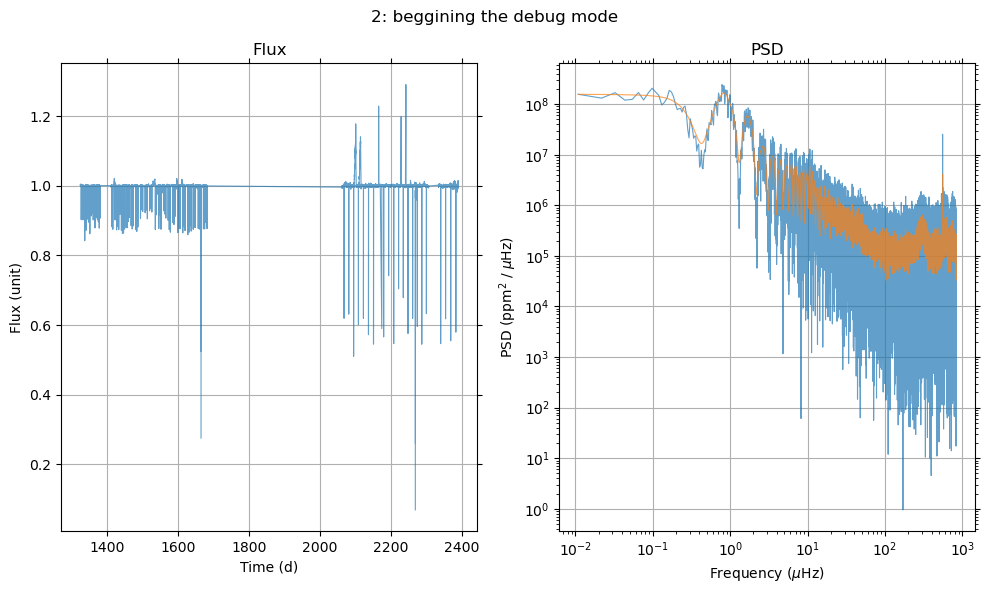

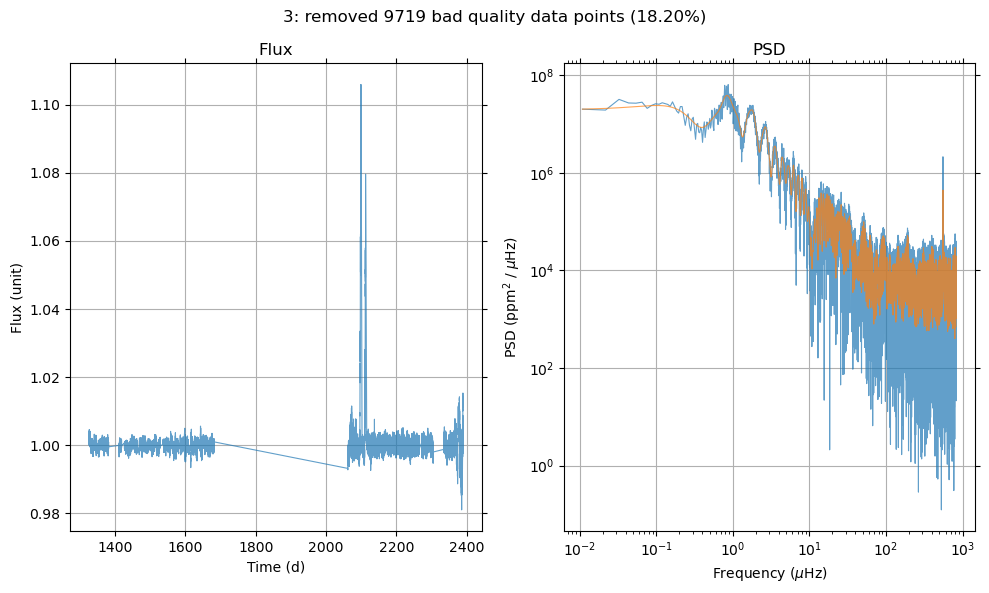

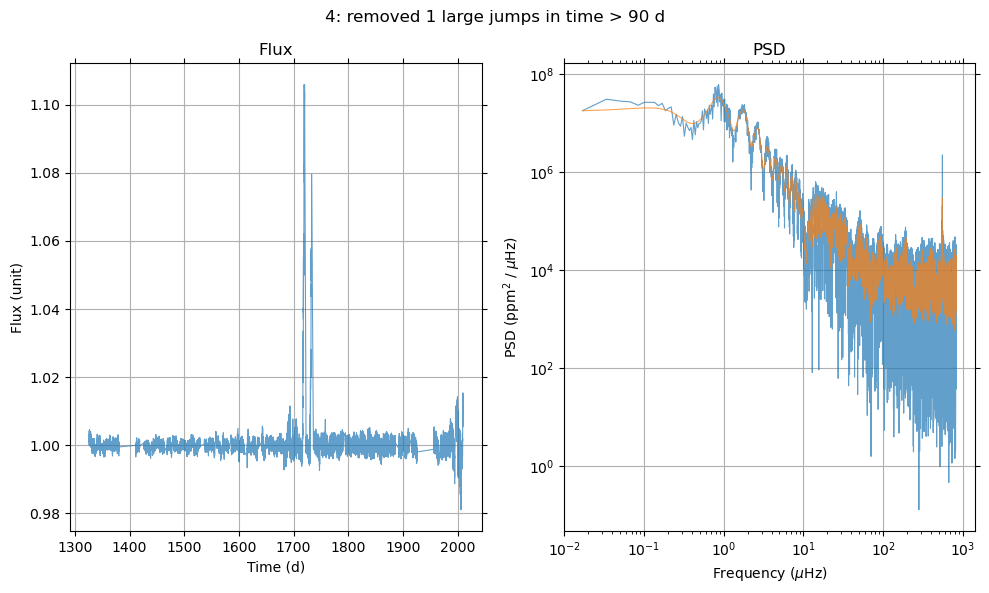

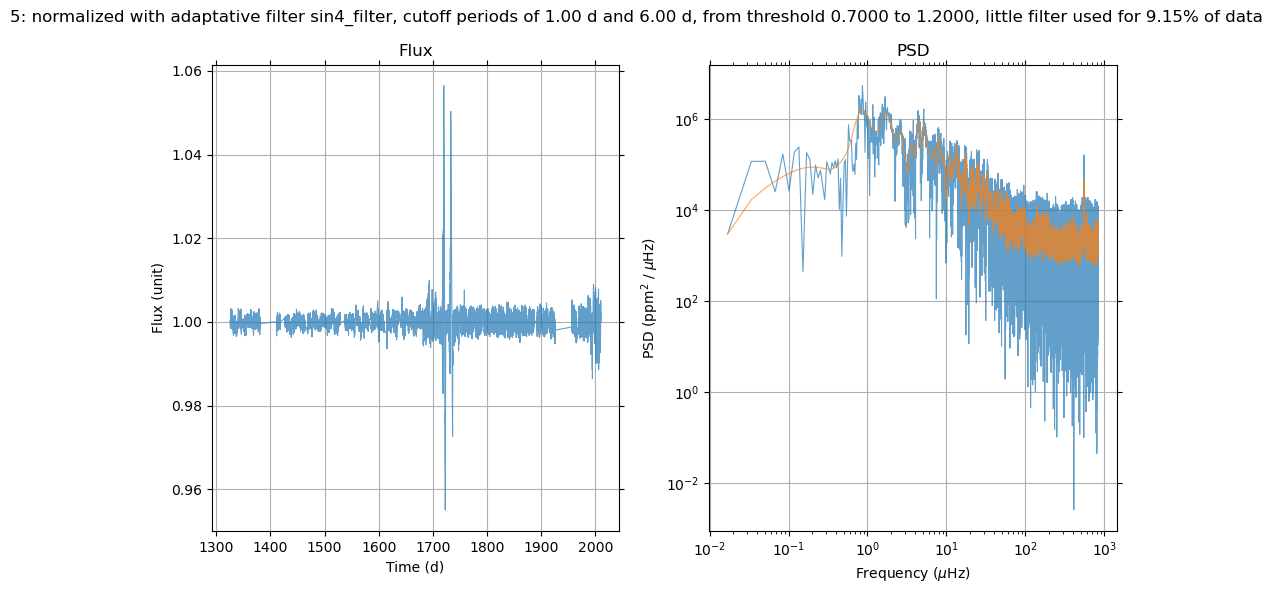

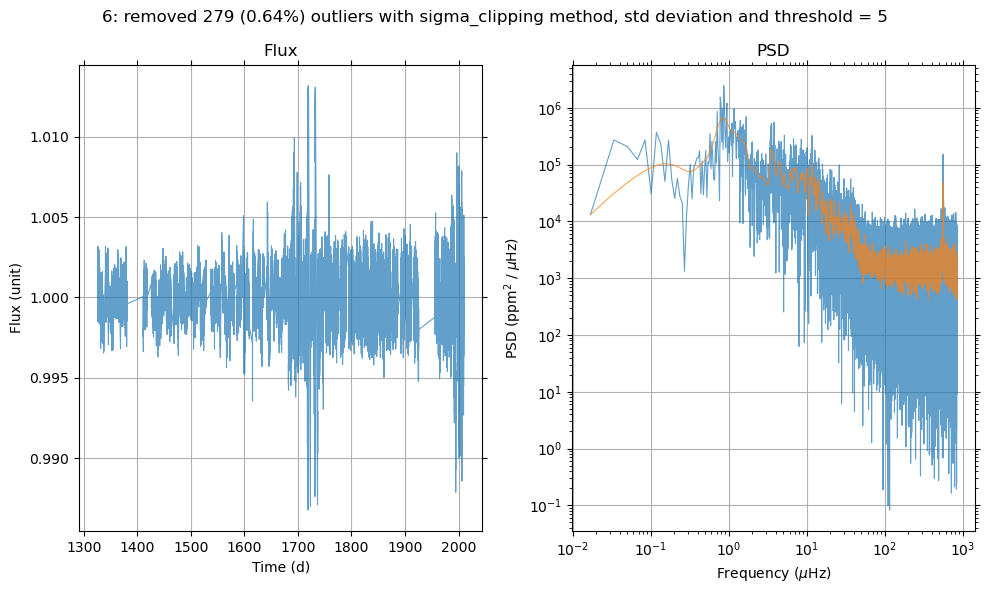

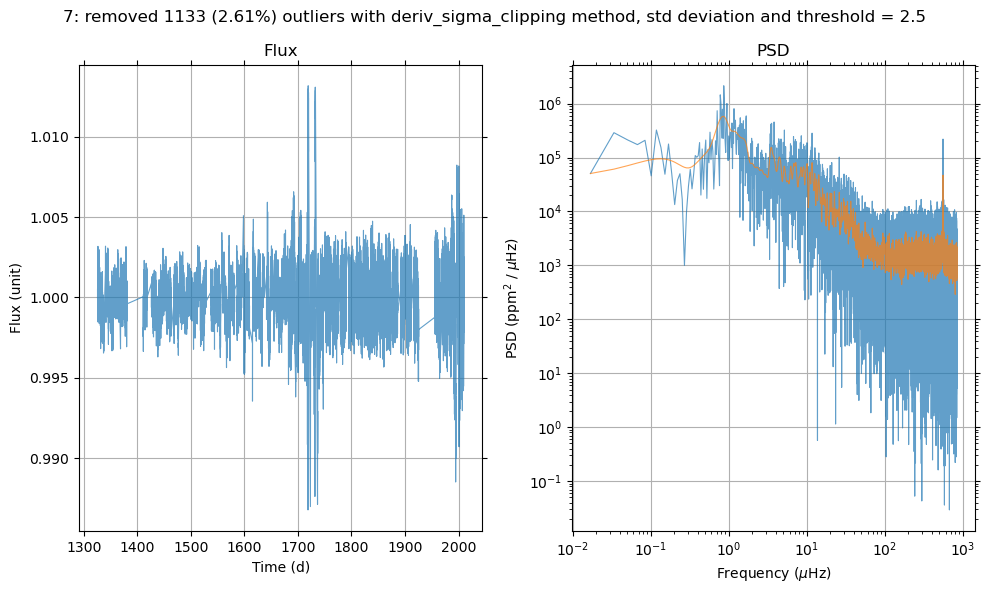

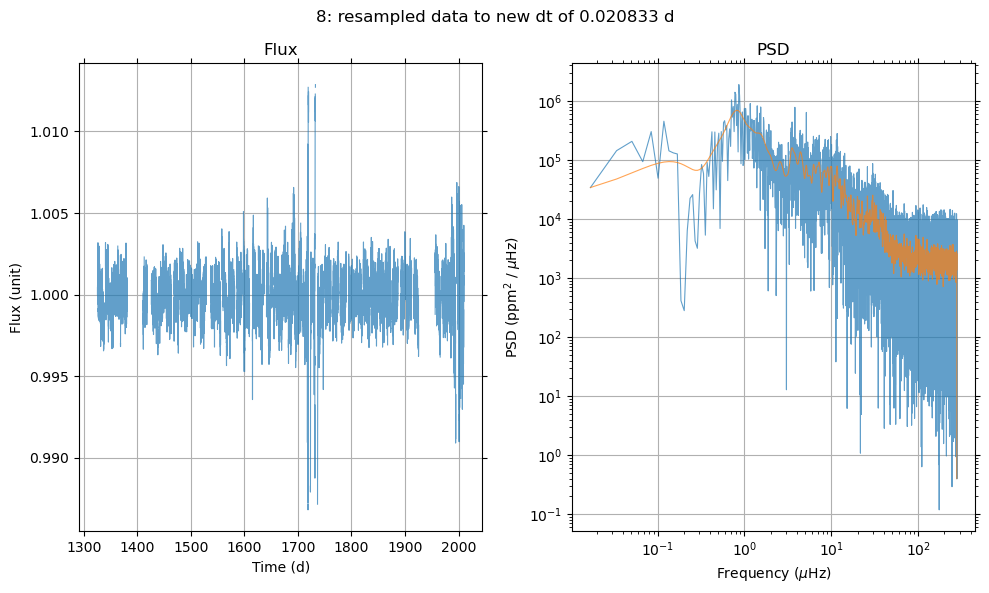

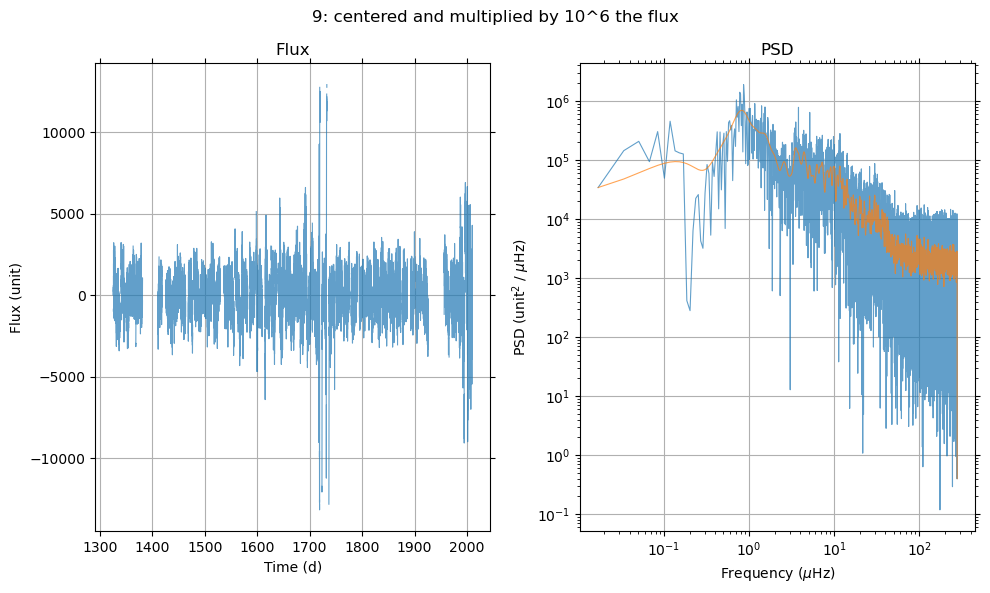

In [7]:
lc_4.print_operations()

Finally, we can do *exactly* what we just did again, but in a much more performant and readable way (by not copying the lightcurve each time, and disabling debug saves).

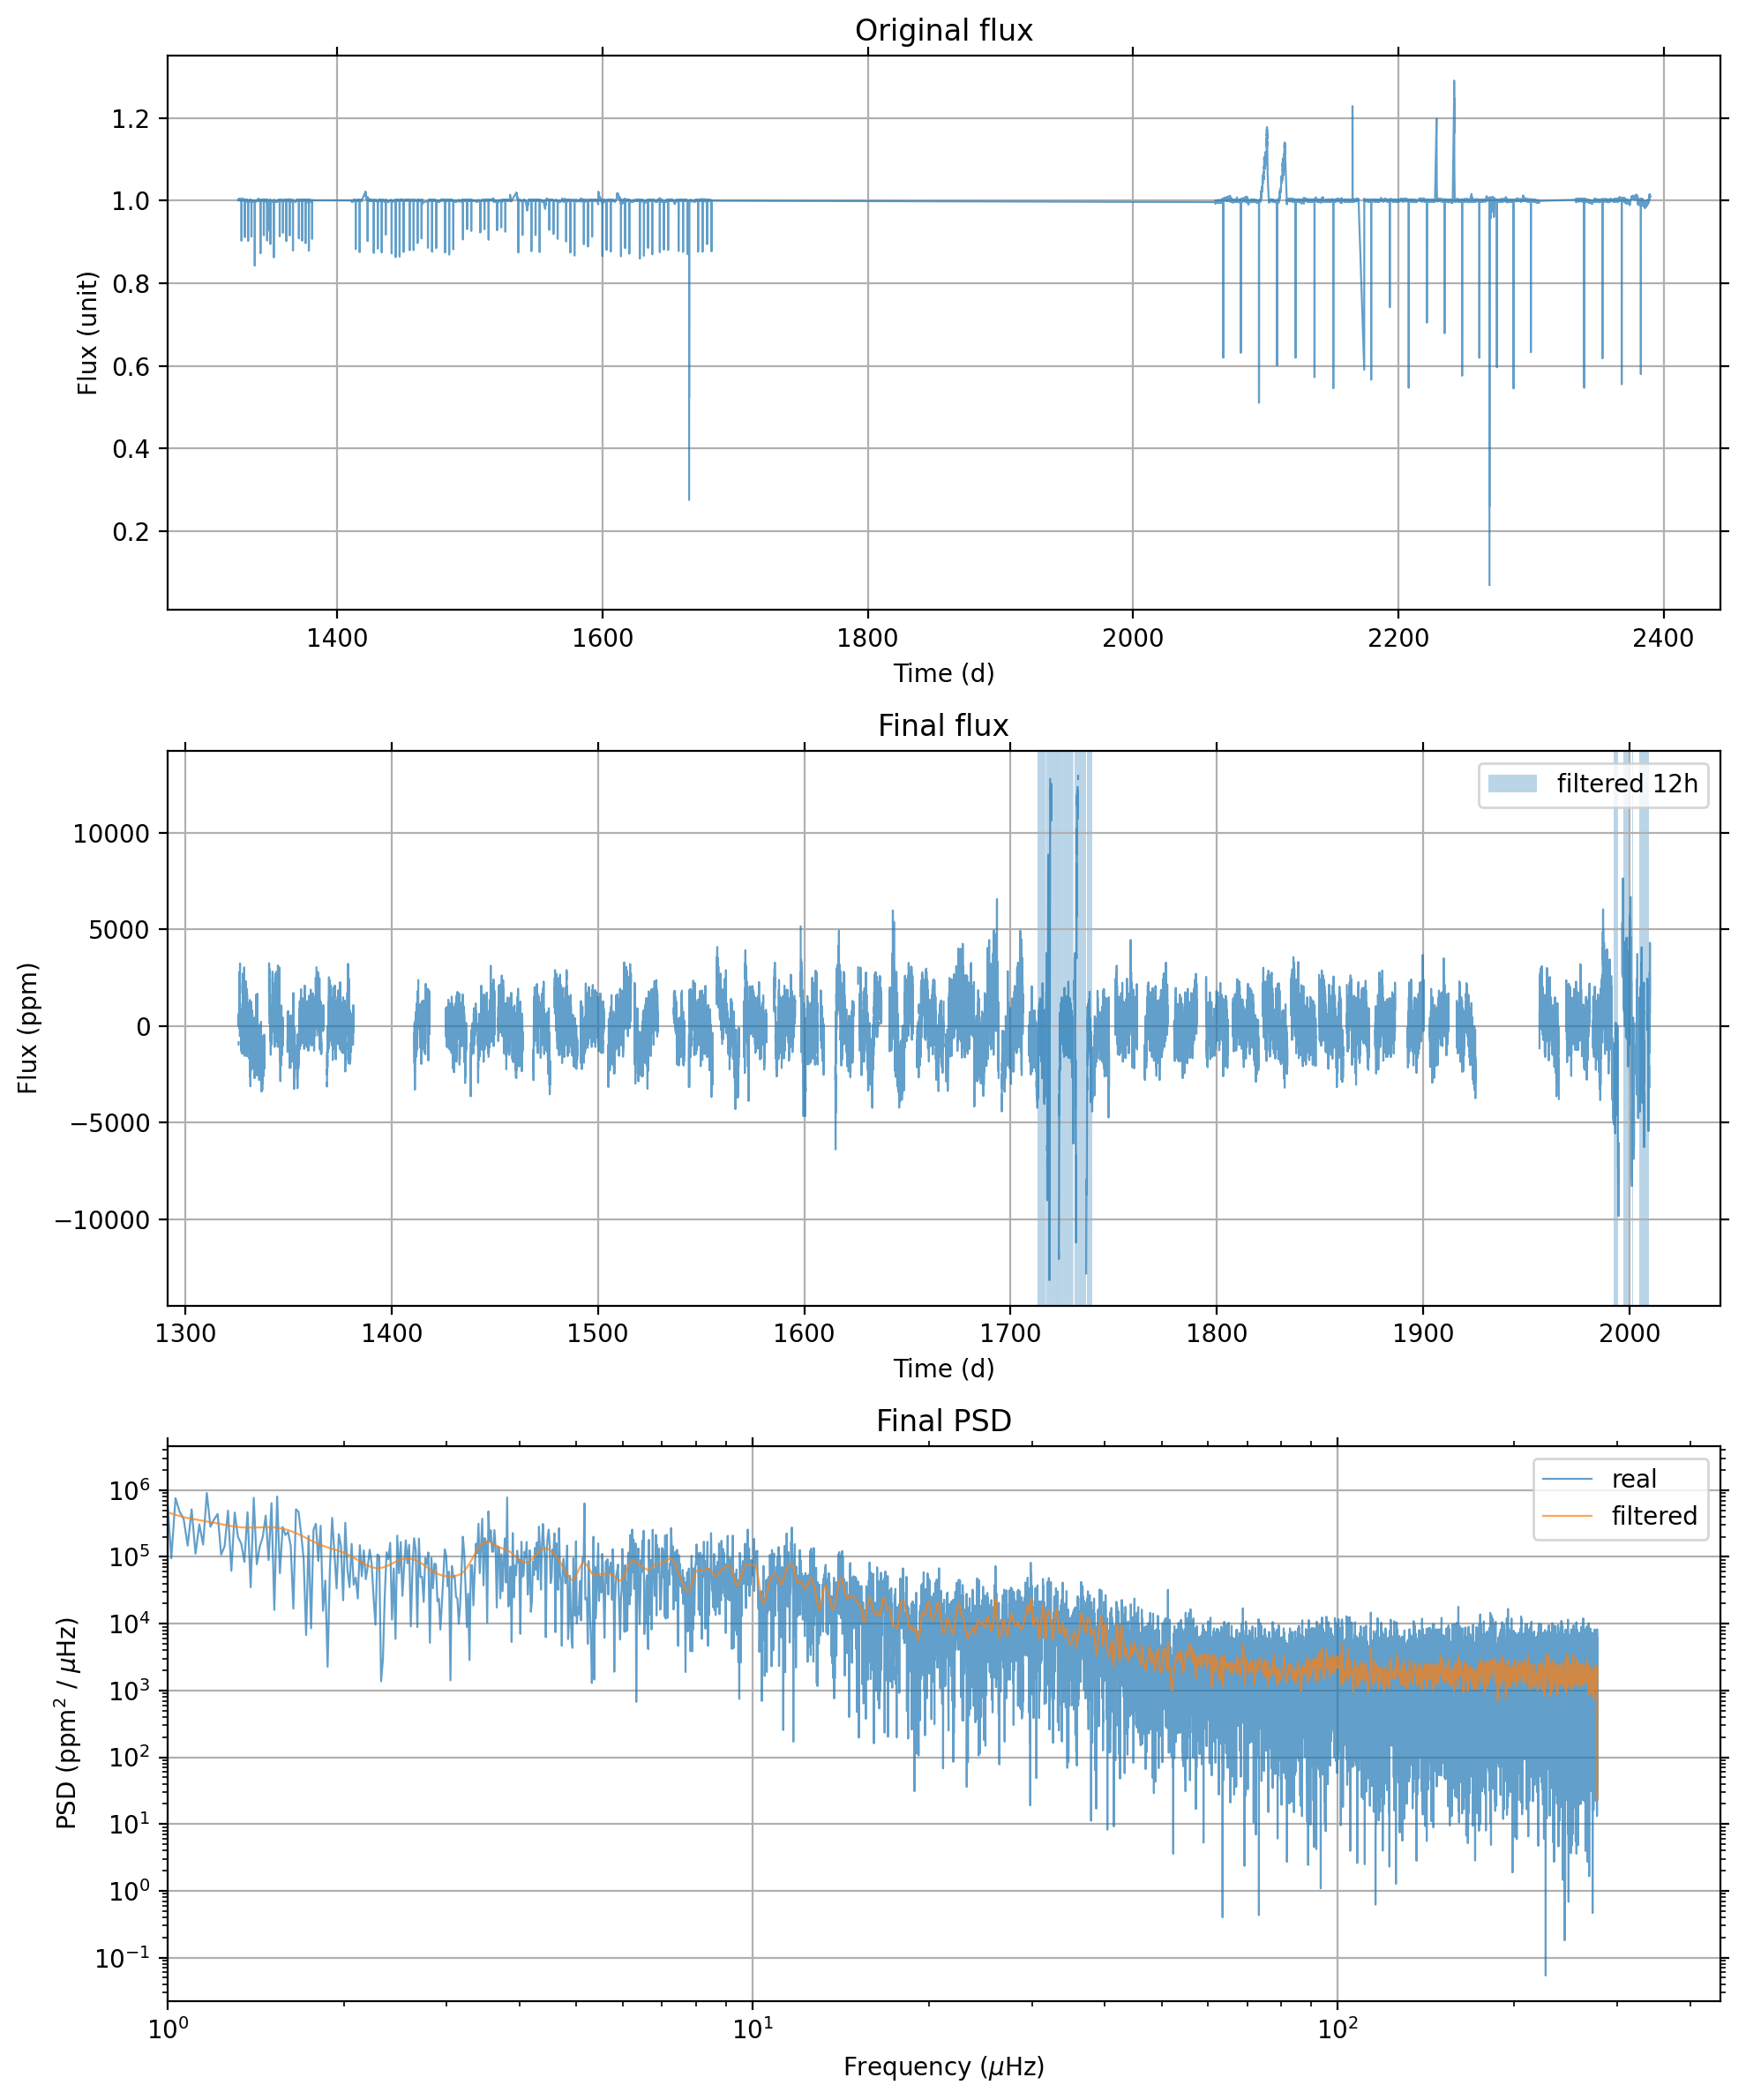

In [ ]:
# create the lightcurve and initialize it from a folder containing multiple FITS files
lc = Lightcurve().load_qlp("data/4MOST/0000000260501932/qlp/")

# already create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12), dpi=200)

# plot the original flux
lc.plot_flux(ax=ax1, title="Original flux")

# remove non-null quality flags and the large gaps (you can chain the method calls!)
lc.remove_quality(quality_to_keep=[0]).remove_large_jumps(90)

# filter the flux with out adaptative filter and show the 12h correction zones
indicator = lc.normalize_adaptative_sin4_filter(
    cut_above_periods=(1, 6), thresholds=(0.7, 1.2), return_indicators=True
)
lc.plot_correction_zones(ax2, correction=indicator, label="filtered 12h")

# remove outliers that are left after the adaptative filter
lc.remove_outliers(identification_mode="sigma_clipping", threshold=5)

# prepare for the PSD
lc.resample(0.5 / 24).flux_to_ppm()

# plot the final flux in the second subplot
lc.plot_flux(ax=ax2, title="Final flux")

# plot the resulting PSD in the third subplot, along with a filtered version of it
lc.plot_psd(ax=ax3, xlim=(1, None), label="real")
lc.plot_psd(
    ax=ax3,
    xlim=(1, None),
    psd_filter=lambda x: sin4_filter(x, 41),
    title="Final PSD",
    label="filtered",
)

# adapt the subplots to their content
fig.tight_layout()